We noticed that the performance of the model significantly declined with the augmentation.
Therefore we are going to run perfoprmance gradient on the model trained on unaugmented data and then compare results

In [ ]:
#@title
# Import files
import tensorflow.keras as keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Sequential
from keras.utils import np_utils
from tensorflow.keras.layers import Dense,Activation, Flatten, Dropout, BatchNormalization, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras import regularizers, optimizers
import tensorflow as tf
from tensorflow.keras.applications import ResNet50,VGG16,ResNet101, VGG19, DenseNet201, EfficientNetB4, MobileNetV2
from tensorflow.keras.applications import resnet, vgg16 , vgg19, densenet, efficientnet, mobilenet_v2
from tensorflow.keras import Model

from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, MaxPool2D, Conv2D, Flatten
from tensorflow.keras.metrics import categorical_crossentropy


import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import PIL
import os
import cv2

import warnings
warnings.filterwarnings('ignore')

from keras.models import model_from_json
from keras.optimizers import SGD
from google.colab.patches import cv2_imshow

from os import listdir
from os.path import isfile, join
import numpy
import cv2

import pandas as pd
import imgaug.augmenters as iaa

# import test, train, and validation folders:
import skimage

from keras.models import model_from_json
from keras.optimizers import SGD
from google.colab.patches import cv2_imshow

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
! pip install -Uq kaggle
! pip install -Uq fastai==2.2.5

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 191.2/191.2 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.0/56.0 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 776.8/776.8 MB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.7/12.7 MB 70.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchtext 0.15.1 requires torch==2.0.0, but you have torch 1.7.1 which is incompatible.
torchdata 0.6.0 requires torch==2.0.0, but you have torch 1.7.1 which is incompatible.
torchaudio 2.0.1+cu118 requires torch==2.0.0, but you have torch 1.7.1 which is incompatible.


In [ ]:
from google.colab import files 
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"shreyashukla01","key":"b0652e31cce9e0350fd087c244990d74"}'}

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download -d mohamedhanyyy/chest-ctscan-images

 97% 115M/119M [00:04<00:00, 21.9MB/s]
100% 119M/119M [00:04<00:00, 26.0MB/s]


In [ ]:
! unzip -qq chest-ctscan-images.zip

In [ ]:
# Load VGG model from json

#Load the Model from Json File
json_file = open('/content/gdrive/My Drive/SML_Project/model_vgg16.json', 'r')
model_json_c = json_file.read()
json_file.close()
model = model_from_json(model_json_c)
#Load the weights
model.load_weights("/content/gdrive/My Drive/SML_Project/chest_CT_SCAN-VGG16.hdf5")
#Compile the model
opt = SGD(lr=1e-4, momentum=0.9)
model.compile(loss="categorical_crossentropy", optimizer=opt,metrics=["accuracy"])

# Gradient Functions

In [ ]:
# Downsampling of Image Function 
def downsampleImage(images, stride): 
  ''' 
  Input: 
  image  - you want to undersample
  stride - the number of rows and columns you want to skip from original image
  '''
  downsampled_images = []
  for i in range(len(images)): 
    pixelated_image = images[i][::stride, ::stride] 
    downsampled_images.append(pixelated_image)
  return downsampled_images

# Downsampling gradient

In [ ]:
# Directories for image contrast dataset
! mkdir underSampledImages
! mkdir underSampledImages/stride/
! mkdir underSampledImages/stride/0
! mkdir underSampledImages/stride/0/cancerous
! mkdir underSampledImages/stride/0/non_cancerous
! mkdir underSampledImages/stride/1
! mkdir underSampledImages/stride/1/cancerous
! mkdir underSampledImages/stride/1/non_cancerous
! mkdir underSampledImages/stride/2
! mkdir underSampledImages/stride/2/cancerous
! mkdir underSampledImages/stride/2/non_cancerous
! mkdir underSampledImages/stride/3
! mkdir underSampledImages/stride/3/cancerous
! mkdir underSampledImages/stride/3/non_cancerous
! mkdir underSampledImages/stride/4
! mkdir underSampledImages/stride/4/cancerous
! mkdir underSampledImages/stride/4/non_cancerous

In [ ]:
# Create a new dataset with cancerous and non cancerous images
! mkdir ct_scan

! mkdir ct_scan/test
! mkdir ct_scan/test/cancerous
! mkdir ct_scan/test/non_cancerous
! cp -r Data/test/adenocarcinoma/. ct_scan/test/cancerous/
! cp -r Data/test/large.cell.carcinoma/. ct_scan/test/cancerous/
! cp -r Data/test/squamous.cell.carcinoma/. ct_scan/test/cancerous/
! cp -r Data/test/normal/. ct_scan/test/non_cancerous/

In [ ]:
cancer_test_path = "ct_scan/test/cancerous/"
noncancer_test_path = "ct_scan/test/non_cancerous/"

In [ ]:
# Test - Cancer Downsampling Images  
images = []
for path in os.listdir(cancer_test_path):
  image_ = cv2.imread(cancer_test_path+'/'+path)
  images.append(image_)

strides = [2, 4, 6, 8, 10] # number of rows and columns to skip from the original image
for j in range(len(strides)): 
  count = 0 
  undersampled_images = downsampleImage(images, strides[j])
  for i in range(len(undersampled_images)):
      undersampledimage = undersampled_images[i]
      cv2.imwrite(f"underSampledImages/stride/{j}/cancerous/{i}.jpg",undersampledimage)
      count +=1
      k = cv2.waitKey(1000)
  print(f"Number of Undersampled Cancer Images of stride = {strides[j]} : {count}")

# Test - Non Cancer Undersampled Images
images = []
for path in os.listdir(noncancer_test_path):
  image_ = cv2.imread(noncancer_test_path+'/'+path)
  images.append(image_)

strides = [2, 4, 6, 8, 10] # number of rows and columns to skip from the original image
for j in range(len(strides)): 
  count = 0 
  undersampled_images = downsampleImage(images, strides[j])
  for i in range(len(undersampled_images)):
      undersampledimage = undersampled_images[i]
      cv2.imwrite(f"underSampledImages/stride/{j}/non_cancerous/{i}.jpg",undersampledimage)
      count +=1
      k = cv2.waitKey(1000)
  print(f"Number of Undersampled Non Cancer Images of stride = {strides[j]} : {count}")

Number of Undersampled Cancer Images of stride = 2 : 224
Number of Undersampled Cancer Images of stride = 4 : 224
Number of Undersampled Cancer Images of stride = 6 : 224
Number of Undersampled Cancer Images of stride = 8 : 224
Number of Undersampled Cancer Images of stride = 10 : 224
Number of Undersampled Non Cancer Images of stride = 2 : 54
Number of Undersampled Non Cancer Images of stride = 4 : 54
Number of Undersampled Non Cancer Images of stride = 6 : 54
Number of Undersampled Non Cancer Images of stride = 8 : 54
Number of Undersampled Non Cancer Images of stride = 10 : 54


In [ ]:
# testgenerator for underSampledImages

N_CLASSES = 2
BATCH_SIZE = 32

test_datagen = ImageDataGenerator(dtype='float32')
test_losses_undersampled = []
test_accuracy_list_undersampled = []
for i in range(len(strides)):
  test_path = f"underSampledImages/stride/{i}"
  test_generator = test_datagen.flow_from_directory(test_path,
                                                   batch_size = BATCH_SIZE,
                                                   target_size = (460,460),
                                                   class_mode = 'categorical')
  test_loss, test_accuracy = model.evaluate(test_generator)
  test_losses_undersampled.append(test_loss)
  test_accuracy_list_undersampled.append(test_accuracy)
  print(test_losses_undersampled)
  print(test_accuracy_list_undersampled)

Found 278 images belonging to 2 classes.
9/9 [==============================] - 700s 76s/step - loss: 3.1313 - accuracy: 0.2878
[3.131295919418335]
[0.28776979446411133]
Found 278 images belonging to 2 classes.
9/9 [==============================] - 692s 77s/step - loss: 6.4310 - accuracy: 0.1655
[3.131295919418335, 6.4309821128845215]
[0.28776979446411133, 0.16546761989593506]
Found 278 images belonging to 2 classes.
9/9 [==============================] - 693s 76s/step - loss: 3.1613 - accuracy: 0.1978
[3.131295919418335, 6.4309821128845215, 3.1613047122955322]
[0.28776979446411133, 0.16546761989593506, 0.19784173369407654]
Found 278 images belonging to 2 classes.
9/9 [==============================] - 687s 76s/step - loss: 1.0877 - accuracy: 0.4604
[3.131295919418335, 6.4309821128845215, 3.1613047122955322, 1.0877244472503662]
[0.28776979446411133, 0.16546761989593506, 0.19784173369407654, 0.46043166518211365]
Found 278 images belonging to 2 classes.
9/9 [============================

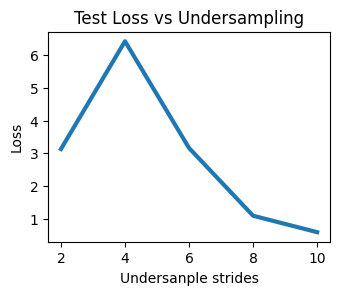

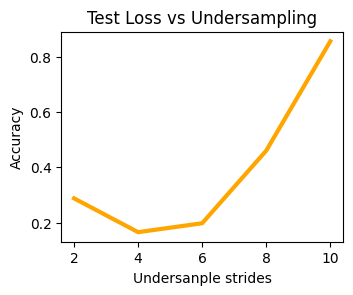

In [ ]:
# Graph for the trend


# plot loss vs Undersampling
plt.figure(figsize=(8,6))
plt.subplot(221)
plt.plot(strides, test_losses_undersampled, linewidth=3)
plt.title('Test Loss vs Undersampling')
plt.xlabel('Undersanple strides')
plt.ylabel('Loss')
plt.show()

# plot accuracy vs Undersampling
plt.figure(figsize=(8,6))
plt.subplot(222)
plt.plot(strides, test_accuracy_list_undersampled, color = "orange", linewidth=3)
plt.title('Test Loss vs Undersampling')
plt.xlabel('Undersanple strides')
plt.ylabel('Accuracy')
plt.show()

# ResNet-50 trained on Augmented data

In [ ]:
# Load ResNet model from json

#Load the Model from Json File
json_file = open('/content/gdrive/My Drive/SML_Project/model_resnet50_augmented.json', 'r')
model_json_c = json_file.read()
json_file.close()
model_r = model_from_json(model_json_c)
#Load the weights
model_r.load_weights("/content/gdrive/My Drive/SML_Project/chest_CT_SCAN-ResNet50_augmented.hdf5")
#Compile the model
opt = SGD(lr=1e-4, momentum=0.9)
model_r.compile(loss="categorical_crossentropy", optimizer=opt,metrics=["accuracy"])

In [ ]:
# testgenerator for underSampledImages

N_CLASSES = 2
BATCH_SIZE = 32

test_datagen = ImageDataGenerator(dtype='float32')
test_losses_undersampled_r = []
test_accuracy_list_undersampled_r = []
for i in range(len(strides)):
  test_path = f"underSampledImages/stride/{i}"
  test_generator = test_datagen.flow_from_directory(test_path,
                                                   batch_size = BATCH_SIZE,
                                                   target_size = (460,460),
                                                   class_mode = 'categorical')
  test_loss, test_accuracy = model_r.evaluate(test_generator)
  test_losses_undersampled_r.append(test_loss)
  test_accuracy_list_undersampled_r.append(test_accuracy)
  print(test_losses_undersampled_r)
  print(test_accuracy_list_undersampled_r)

Found 278 images belonging to 2 classes.
9/9 [==============================] - 265s 29s/step - loss: 0.1138 - accuracy: 0.9964
[0.1137930378317833]
[0.9964028596878052]
Found 278 images belonging to 2 classes.
9/9 [==============================] - 264s 29s/step - loss: 0.2902 - accuracy: 0.9496
[0.1137930378317833, 0.29024118185043335]
[0.9964028596878052, 0.9496402740478516]
Found 278 images belonging to 2 classes.
9/9 [==============================] - 260s 29s/step - loss: 0.6461 - accuracy: 0.5863
[0.1137930378317833, 0.29024118185043335, 0.6460891962051392]
[0.9964028596878052, 0.9496402740478516, 0.5863309502601624]
Found 278 images belonging to 2 classes.
9/9 [==============================] - 258s 28s/step - loss: 0.8280 - accuracy: 0.3129
[0.1137930378317833, 0.29024118185043335, 0.6460891962051392, 0.8279598951339722]
[0.9964028596878052, 0.9496402740478516, 0.5863309502601624, 0.31294962763786316]
Found 278 images belonging to 2 classes.
9/9 [==============================

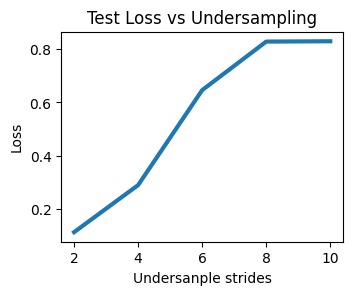

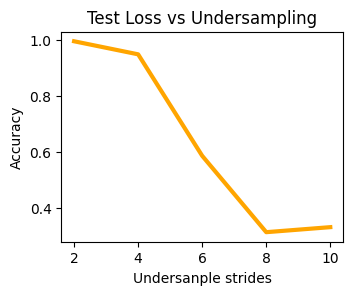

In [ ]:
# Graph for the trend


# plot loss vs Undersampling
plt.figure(figsize=(8,6))
plt.subplot(221)
plt.plot(strides, test_losses_undersampled_r, linewidth=3)
plt.title('Test Loss vs Undersampling')
plt.xlabel('Undersanple strides')
plt.ylabel('Loss')
plt.show()

# plot accuracy vs Undersampling
plt.figure(figsize=(8,6))
plt.subplot(222)
plt.plot(strides, test_accuracy_list_undersampled_r, color = "orange", linewidth=3)
plt.title('Test Loss vs Undersampling')
plt.xlabel('Undersanple strides')
plt.ylabel('Accuracy')
plt.show()